# Calibration refinement

In this notebook, the initially calculated camera calibration parameters are refined through an adaptive tomography routine using particle swarm optimization (PSO).

*Note*: this notebook requires a CUDA-capable GPU for 3D tomographic reconstruction using the *ASTRA* toolbox. If none is available, move on to the next step in the workflow ([pb04_reconstruction.ipynb](./pb03_reconstruction.ipynb)) where pre-computed PSO results will be used instead.

---

## Environment setup

In [1]:
import glob
import h5py
import ipywidgets as widgets
import json
import numpy as np

from ipywidgets import (
                        interact,
                        fixed
                        )
from PIL import Image

from preproc_utilities import showSprayPB
from recon_utilities import (
                             loadSpray,
                             getSystemMatrix,
                             MLOS
                             )
from refine_utilities import (
                              geomVec,
                              setupConstraints,
                              geomDict,
                              showGeom,
                              getError,
                              compareProj,
                              optimize
                              )


# Data directories
inp_fld = 'inputs'
out_fld = 'outputs'

### Version information

In [2]:
%reload_ext watermark
%watermark -p h5py,ipywidgets,json,numpy,PIL
%watermark -p cv2,matplotlib,pyswarms,scipy,skimage

h5py 2.10.0
ipywidgets 7.6.3
json 2.0.9
numpy 1.19.5
PIL 8.4.0
cv2 3.2.0
matplotlib 3.1.1
pyswarms 1.3.0
scipy 1.1.0
skimage 0.15.0


## Initial geometry setup
The experimental geometry parameters required for reconstruction of the polychromatic beam results includes the location of the X-ray anode, the location of the scintillator detector, and the axes defining the orientation of the detection plane. These parameters can be initially constructed using the camera calibration output (see: [pb01_calibration.ipynb](./pb01_calibration.ipynb)). By design, all of these parameters are taken to be relative to an origin point from one of the dot target views used for camera calibration.

Let's first load in the camera calibration (`camCal`) and standard deviation (`errCal`) values.

In [3]:
# Load in camera calibrations
cal_c1 = np.load(f'{out_fld}/cam1_calibration.npz')
cal_c2 = np.load(f'{out_fld}/cam2_calibration.npz')
cal_c3 = np.load(f'{out_fld}/cam3_calibration.npz')
camCal = [x['cal'].tolist() for x in [cal_c1, cal_c2, cal_c3]]
errCal = [x['err'].tolist() for x in [cal_c1, cal_c2, cal_c3]]

The next step is to define the detector size in mm/px **on the detector plate**. This was pre-determined by placing an object of known size at the detection plate and roughly counting the number of pixels in length for each camera. Due to general measurement uncertainty, this parameter is also fit during the refinement process.

In [4]:
det_size = np.array([0.111, 0.111, 0.108])

From the three available calibration plate views, the first one is used to define the origin for the geometry as it has a generally low pixel error across all three cameras.

In [5]:
view = 1

The adaptive refinement process used in this notebook (particle swarm optimization, PSO) operates on vectorized inputs, so the camera calibration parameters are first converted into vector form (see: `geomVec()` in [refine_utilities.py](./refine_utilities.py)).

The `gVec_init` variable contains the initial geometry parameters that will be used for initializing the PSO routine. It is constructed in the following order: camera rotations, camera translations, camera focal lengths, camera principal points, and detector sizes.

In [6]:
# Retrieve geometry parameters as a vector
gVec_init = geomVec(camCal, det_size, view)

We will be doing a constrained PSO routine for a more effective solution strategy. The bounds are calculated using the standard deviations ($\sigma$) from the camera calibration procedure, defined as 3$\sigma$. The `constraints` variable is constructed as a tuple, with the first and second elements containing the lower and upper bound vectors, respectively, for the corresponding elements of `gVec_init` (see: `setupConstraints()` in [refine_utilities.py](./refine_utilities.py)).

In [7]:
# Parameter bounds
constraints = setupConstraints(gVec_init, errCal, view)

The final geometry parameters for the anode locations, detector locations, and detector orientations are contained in the `geom_init` dictionary. The construction is setup such that the camera calibration *extrinsics* ($x$/$y$/$z$ rotations and $x$/$y$/$z$ translations) define the anode location relative to the world origin and the camera calibration *intrinsics* (focal lengths $f_x$ and $f_y$ and principal points $c_x$ and $c_y$) define the detector location relative to the corresponding anode and detector orientation relative to the world origin. This results in 10 parameters per line of sight, or 30 parameters in total that will need to be optimized.

The calculations are done in `geomDict()` (see: [refine_utilities.py](./refine_utilities.py)), which is based off of previous works [[1]](#References), [[2]](#References).

In [8]:
# Dictionary form of the geometry vector
geom_init = geomDict(gVec_init)

A top-down visualization of the initial calibrated locations is shown below. Lines of sight 1, 2, and 3 are shown in red, green, and blue, respectively (corresponding to cameras 1, 2, and 3 and their opposing X-ray sources).

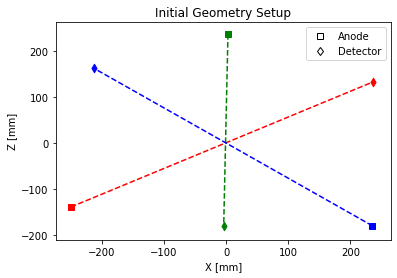

In [9]:
# Top-down perspective of geometry
showGeom(geom_init)

## Reconstruction setup

The projected density maps from the preprocessing step (see: [pb02_preprocessing.ipynb](./pb02_preprocessing.ipynb)) will be used for geometry refinement. Only the lower $Re$ case (open rim condition) is used for refinement here, as it is generally cleaner than the higher $Re$ case (impact wave condition). The spray images are used here instead of the calibration plate images to account for any (hopefully slight) changes that might have occurred between the calibration and spray imaging.

Let's load in the dataset.

In [10]:
# Load in spray images
projRes, _ = loadSpray(f'{out_fld}/spray_pbDens_frame0.hdf5')

Tomographic reconstruction is an inverse problem of the form

$$
Wx = p,
$$

where $x$ is the volume to be reconstructed, $p$ are the initially measured projections, and $W$ is a system matrix that maps the volume onto each of the measured projections. 

The system matrix defines the experimental geometry, and is constructed here using the *ASTRA* toolbox [[3]](#References), [[4]](#References). Let's retrieve the initial system matrix `W_init` using the initial geometry `geom_init` calculated above.

In [11]:
# Retrieve initial system matrix
W_init = getSystemMatrix(geom_init)

For the geometry refinement process, instead of going through an entire iterative reconstruction routine, we will employ a single-step multiplicative line of sight (MLOS) routine, which provides an accurate spatial reconstruction of $x$ based on overlapping regions in the measurements $p$ [[5]](#References), [[6]](#References). This is done on the premise that any misalignments in the geometry parameters will cause a resulting misalignment in the reconstructed structural features. Therefore, we only care about accuracy in the reconstruction of the structural features instead of the intensity gradients for this geometry refinement routine.

Let's calculate an initial volume using the MLOS routine and our initial system matrix (see: `MLOS()` in [recon_utilities.py](./recon_utilities.py)). The outputs of the function are a reconstructed volume `volMLOS` and the projections of that volume `projMLOS`.

In [12]:
# Initial volume guess using initial system matrix
volMLOS, projMLOS = MLOS(W_init, projRes, 'proj', 3)

The cost function utilized in the PSO routine is defined as the number of "missing pixels" in the reprojections as compared against the initial measured projections. This is calculated by binarizing the reprojections and projections and counting the number of pixels that are present in the projection data but not in the reprojection data.

Let's calculate the initial error based on our initial system matrix (see: `getError()` in [refine_utilities.py](./refine_utilities.py)).

In [13]:
# Calculate initial "error"
init_cost = getError(W_init, projRes)

print(f'Initial number of missing pixels: {init_cost}')

Initial number of missing pixels: 1277


The ideal set of geometry parameters should result in a missing pixel count approaching zero, with any deviations explained by object pixelation (due to the discretization of the volume) and uncertainties in the geometry parameters. 

We can visualize the geometry misalignment by mapping the difference between the projection (`projRes`) and reprojection (`projMLOS`) data.

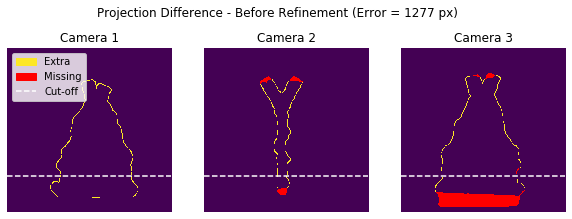

In [14]:
compareProj(projRes, projMLOS, f'Before Refinement (Error = {init_cost} px)')

As shown above, the red region refers to pixels that are missing in the reprojection while the yellow region refers to pixels that are present in the reprojection but not in the projection data. We will assume that we can take care of the extra pixels through smoothing in the final iterative reconstruction routine, however the missing pixels cannot be recovered in the final iterative reconstruction routine due to geometry misalignments inherent in the initial system matrix `W_init`.

Some parts of the jets are "missing" in the camera 2 and 3 reprojections. The white dashed line refers to the cut-off used in the PSO routine$-$because camera 3 sees more of the spray than camera 1 and 2, only the missing pixels above the white dashed line are considered in the PSO routine.

With the problem now setup, let's continue onto the PSO section where we will try to estimate a better `W` system matrix so as to reduce the number of red "missing" pixels.

## Particle swarm optimization

Particle swarm optimization (PSO) is an optimization algorithm that seeks to find the global minimum of an objective function through a randomized set of particles that operate together, much like "bird flocking" and "fish schooling" [[7]](#References). 

A set of particles (or workers) are given an initial random state to evaluate the given objective function$-$based on how well their corresponding cost (or error) values are as well as the evaluated cost of the particles around them, their positions are updated and the objective function evaluation is repeated. This optimization routine is an iterative solution, with convergence achieved when the change in particle positions have stalled out. 

PSO is defined as a metaheuristic as it does not guarantee that the global minimum will be found$-$nonetheless, it is considered to be a sufficient optimization strategy here as the geometry refinement process can be done "blindly" (without need of defining a gradient function). The optimization routine is typically defined by three hyper-parameters that control how the particle's positions are updated between iterations: a cognitive parameter (how much bias the particle puts towards its own solution), a social parameter (how much bias the particle puts towards the neighboring solutions), and an inertia parameter (controls the magnitude in change of the particle's positions). For further reference, see previous publications that cover PSO such as [[7]](#References) and [[8]](#References).

<img src="https://i.imgur.com/IhbKTIE.gif" alt="PSO visualization" style="width: 400px;"/>
(<a href="https://pyswarms.readthedocs.io/en/development/examples/visualization.html">image source</a>)

In this work, the *PySwarms* research toolkit is used to set up the PSO routine [[8]](#References). The initial particle positions are taken to be the initial geometry vector `gVec_init` (see above), and the objective function is taken to be the "missing pixel" procedure (see: `getError()` in [refine_utilities.py](./refine_utilities.py)). The function is optimized using the `constraints`, and an adaptive hyper-parameter approach is taken such that the cognitive ($c_1$), social ($c_2$), and inertia ($w$) parameters change at each iteration to discourage particles from stalling out. This is defined in the `start_opts` (hyper-parameter starting values) and `end_opts` (hyper-parameter ending values) variables. A swarm size of 50 particles is used over 50 total iterations$-$a two-stage start/stop routine is also utilized to encourage the particles move quicker towards the (assumedly singular) global minimum. For more documentation on how the PSO algorithm is setup here, refer to `optimize()` in [refine_utilities.py](./refine_utilities.py).

In [15]:
init_pos = gVec_init
start_opts = {'c1': 0.5, 'c2': 2.5, 'w': 0.4, 'k': 7, 'p': 1}
end_opts = {'c1': 2.5, 'c2': 0.5, 'w': 0.9}
oh_strategy = {'w': 'nonlin_mod', 'c1': 'nonlin_mod', 'c2': 'exp_decay'}
iters = 50
swarm_size = 50

for i in range(2):
    print(f'Starting Stage {i+1}')
    cost, joint_vars, optimizer = optimize(
                                           projRes,
                                           iters, 
                                           swarm_size, 
                                           len(init_pos), 
                                           constraints, 
                                           init_pos, 
                                           oh_strategy, 
                                           start_opts, 
                                           end_opts
                                           )
    init_pos = joint_vars
    print('')

print('')
print(f'Initial cost = {init_cost} --> Final cost = {cost}')

Starting Stage 1
Wed Mar 23 00:21:59 2022
Iteration: 0 | Options: c1=0.500, c2=4.893, w=0.400 | Cost: 1277.0
Elapsed time: 0.72 min | Time left: 35 min | ETA: Wed Mar 23 00:58:00 2022
Iteration: 1 | Options: c1=0.548, c2=4.327, w=0.412 | Cost: 1277.0
Elapsed time: 1.44 min | Time left: 34 min | ETA: Wed Mar 23 00:57:53 2022
Iteration: 2 | Options: c1=0.596, c2=3.932, w=0.424 | Cost: 1184.0
Elapsed time: 2.15 min | Time left: 34 min | ETA: Wed Mar 23 00:57:47 2022
Iteration: 3 | Options: c1=0.643, c2=3.640, w=0.436 | Cost: 1184.0
Elapsed time: 2.87 min | Time left: 33 min | ETA: Wed Mar 23 00:57:51 2022
Iteration: 4 | Options: c1=0.690, c2=3.417, w=0.448 | Cost: 1184.0
Elapsed time: 3.60 min | Time left: 32 min | ETA: Wed Mar 23 00:57:56 2022
Iteration: 5 | Options: c1=0.738, c2=3.241, w=0.459 | Cost: 1184.0
Elapsed time: 4.31 min | Time left: 32 min | ETA: Wed Mar 23 00:57:55 2022
Iteration: 6 | Options: c1=0.784, c2=3.100, w=0.471 | Cost: 959.0
Elapsed time: 5.04 min | Time left: 31 m

## Results

Let's visualize the refined geometry's reconstruction.

In [16]:
W_pso = getSystemMatrix(geomDict(joint_vars))
volPSO, projPSO = MLOS(W_pso, projRes, 'proj', 3, fp='reconInit_lo')

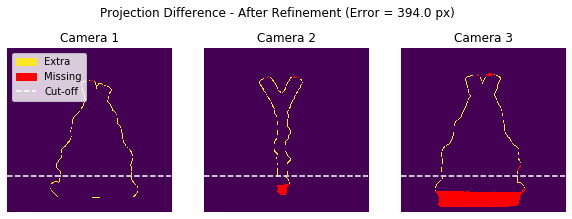

In [17]:
compareProj(projRes, projPSO, f'After Refinement (Error = {cost} px)')

We see that we have recovered more of the previously red region from this refinement procedure (less of the jets are red!).

## Save refined geometry
The final refined geometry is saved in a text file for use in the reconstruction step.

In [18]:
with open(f'{out_fld}/geom_pso.txt', 'w') as file:
     file.write(json.dumps(geomDict(joint_vars), indent=1))

## Next steps
After calibration refinement, the next step in the workflow is [pb04_reconstruction.ipynb](./pb03_reconstruction.ipynb).

## References

1. Albiol, F., Corbi, A. & Albiol, A. Evaluation of modern camera calibration techniques for conventional diagnostic X-ray imaging settings. *Radiol Phys Technol* 10, 68–81 (2017). doi: [10.1007/s12194-016-0369-y](https://doi.org/10.1007/s12194-016-0369-y).


2. Li, X., Zhang, D. & Liu, B. A generic geometric calibration method for tomographic imaging systems with flat-panel detectors-A detailed implementation guide: Geometric calibration method for tomographic imaging systems. *Med. Phys.* 37, 3844–3854 (2010). doi: [10.1118/1.3431996](https://doi.org/10.1118/1.3431996).

3. van Aarle, W. et al. The ASTRA Toolbox: A platform for advanced algorithm development in electron tomography. *Ultramicroscopy* 157, 35–47 (2015). doi: [10.1016/j.ultramic.2015.05.002](https://doi.org/10.1016/j.ultramic.2015.05.002).

4. van Aarle, W. et al. Fast and flexible X-ray tomography using the ASTRA toolbox. *Opt. Express* 24, 25129 (2016). doi: [10.1364/OE.24.025129](https://doi.org/10.1364/OE.24.025129).


5. Atkinson, C. & Soria, J. An efficient simultaneous reconstruction technique for tomographic particle image velocimetry. *Exp. Fluids* 47, 553–568 (2009). doi: [10.1007/s00348-009-0728-0](https://doi.org/10.1007/s00348-009-0728-0).

6. Worth, N. A. & Nickels, T. B. Acceleration of Tomo-PIV by estimating the initial volume intensity distribution. *Exp. Fluids* 45, 847–856 (2008). doi: [10.1007/s00348-008-0504-6](https://doi.org/10.1007/s00348-008-0504-6).

7. Kennedy, J. & Eberhart, R. Particle swarm optimization. in *Proceedings of ICNN’95 - International Conference on Neural Networks* vol. 4 1942–1948 (IEEE, 1995). doi: [10.1109/ICNN.1995.488968](https://doi.org/10.1109/ICNN.1995.488968).

8. James V. Miranda, L. PySwarms: a research toolkit for Particle Swarm Optimization in Python. *JOSS* 3, 433 (2018). doi: [10.21105/joss.00433](https://doi.org/10.21105/joss.00433).

---

**Author**: Naveed Rahman, Purdue University, 23 March 2022

---